In [1]:
%matplotlib inline

from pathlib import Path
from drone_detector.tiling import *
import os, sys
import geopandas as gpd

# Make data

In [2]:
tile_folder = Path('../data/hiidenportti/raw/plot_patches/')
vector_folder = Path('../data/hiidenportti/raw/vector_plots/')

outpath = Path('../data/hiidenportti/processed_unet/')

if not os.path.exists(outpath): os.makedirs(outpath)

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('shp')]
assert len(tiles) == len(vectors)

In [3]:
import rasterio as rio

In [ ]:
for t in tiles:
    with rio.open(tile_folder/t) as f:
        im = f.read()
        tilesize = min(im.shape[1], im.shape[2])/8
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = f'{t.split("_")[0]}.shp'
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname)
    for patch in (f'{tiler.vector_path}/{f}' for f in os.listdir(tiler.vector_path) if f.endswith('geojson')):
        gdf = gpd.read_file(patch)
        gdf['geometry'] = gdf.geometry.buffer(0.05)
        gdf.to_file(patch)
    tiler.tile_and_rasterize_vector('groundwood')

# Train model

In [4]:
from fastai.vision.all import *
from drone_detector.visualizations import *
from drone_detector.data import *

def label_func(fn): 
    return str(fn).replace('raster_tiles', 'rasterized_vector_tiles')

In [6]:
fnames = [Path(f'{outpath}/{tile}/raster_tiles/{f}') 
          for tile in [til for til in os.listdir(outpath) if os.path.isdir(outpath/til)]
          for f in os.listdir(outpath/tile/'rasterized_vector_tiles/')]

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   codes=['Standing', 'Fallen'],
                                                   fnames=fnames,
                                                   label_func=label_func,
                                                   item_tfms=[Resize(256)],
                                                   batch_tfms= [
                                                       *aug_transforms(size=224),
                                                       Normalize.from_stats(*imagenet_stats)
                                                   ])

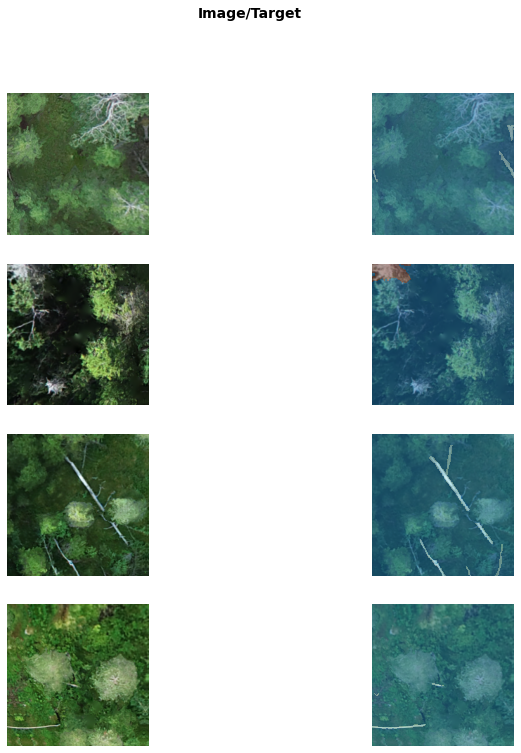

In [10]:
deadwood.show_batch(max_n=8)

In [12]:
from drone_detector.losses import LovaszSoftmaxLossFlat, FocalDice
from drone_detector.metrics import JaccardCoeffMulti

learn = unet_learner(deadwood, resnet101, pretrained=True, n_in=3, n_out=3,
                     metrics=[DiceMulti(), JaccardCoeffMulti()], loss_func=FocalDice()
                    ).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /users/mayrajan/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Because of [this](https://github.com/fastai/fastai/issues/3130) do the following.

SuggestedLRs(valley=7.585775892948732e-05)

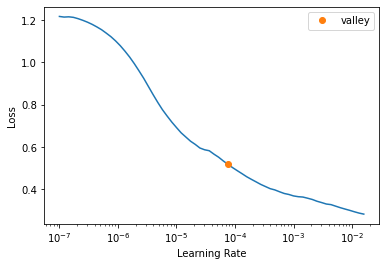

In [13]:
learn.lr_find()

In [14]:
learn.fine_tune(5, freeze_epochs=1, base_lr=1e-4)

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.076616,0.046645,0.597532,0.498973,01:31


epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.037712,0.037981,0.685786,0.572327,01:31
1,0.034066,0.035273,0.664279,0.561397,01:30
2,0.028516,0.030014,0.743903,0.628450,01:30
3,0.025780,0.026530,0.781748,0.671960,01:30
4,0.024264,0.025963,0.777864,0.668074,01:30


In [15]:
learn.to_fp32()

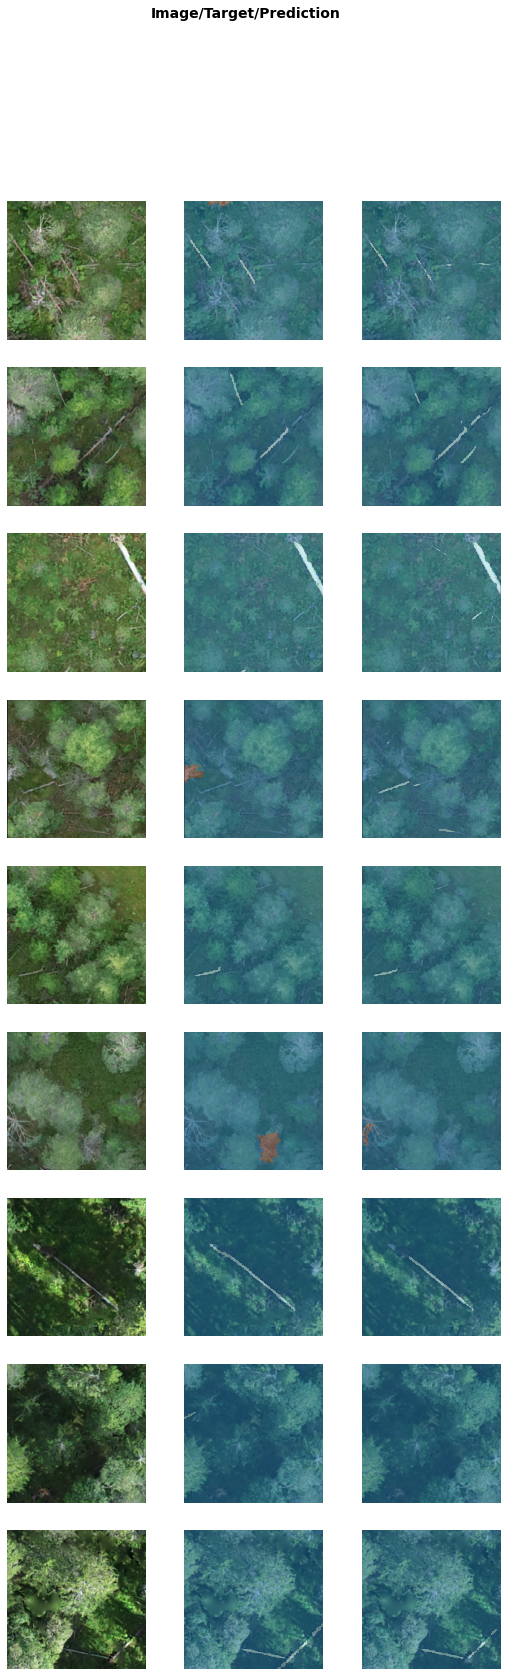

In [16]:
learn.show_results()

In [17]:
learn.export('unet_hiidenportti_focaldice.pkl')

# Test with holdout

In [5]:
learn = load_learner('../data/analysis_data/unet_hiidenportti_focaldice.pkl')

In [6]:
from drone_detector.predict import predict_segmentation

In [7]:
test_rasters = [f'../data/hiidenportti/raw/test_plot_patches/{f}' 
                for f in os.listdir('../data/hiidenportti/raw/test_plot_patches') if f.endswith('tif')]

In [8]:
for t in test_rasters:
    outfile_name = f'../data/hiidenportti/results/unet/{t.split("/")[-1]}'
    predict_segmentation('../data/analysis_data/unet_hiidenportti.pkl', t, outfile_name, tile_size=400, tile_overlap=100)

Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1053_Hiidenportti_Chunk9_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


/opt/conda/lib/python3.8/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
/scratch/mayrajan/drone_detector/drone_detector/metrics.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/10_Hiidenportti_Chunk4_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1035_Hiidenportti_Chunk5_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1025_Hiidenportti_Chunk5_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/109_Hiidenportti_Chunk5_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1047_Hiidenportti_Chunk4_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/11_Hiidenportti_Chunk4_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/114_Hiidenportti_Chunk5_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1038_Hiidenportti_Chunk7_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1033_Hiidenportti_Chunk3_orto.tif to 400x400 tiles with overlap of 100px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


0it [00:00, ?it/s]

Merging predictions
Postprocessing predictions
Removing intermediate files
